# Reduce maintenance costs through predictive techniques

### Goal: Build a predictive model using machine learning to predict the probability of a device failure. The model should minimize false positives and false negatives. 

## Table of Contents

#### 1. Data Exploration
    1.1 Empirical distribution of the attribute values in each column
    1.2 Check for missing data & understand the binary class distribution 
    1.3 Identify columns which are different for failure = 0 & failure = 1 classes
#### 2. Predictive Modelling
    2.1 Overview of Machine Learning & Outcomes
        a. Machine Learning models explored
        b. Model Evaluation Criteria
        c. Results Summary
    2.2 Cross-validation and determination of optimal hyperparameters
    2.3 Decision Tree Analysis
    2.4 Rebuilding the Decision Tree using a reduced set of attributes
    2.5 Neural Network Modelling
    2.6 Logistic Regression
    2.7 Random Forest Classifier
#### 3. Modelling Imbalanced Data
    3.1 Oversampling the minority class (failure = 1)
    3.2 Decision Tree modelling of the Oversampled minority class (failure = 1)
        a. including all attribute columns
        b. including only the reduced attribute columns
    3.3 Oversampling effects on the Logistic Regression model
    3.4 Results Summary (post oversampling)

In [44]:
for name in dir():
 if not name.startswith("_"):
   del globals()[name]

#Import necessary packages
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import graphviz
import itertools

from scipy.stats import ks_2samp
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from scipy import interp
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)

## 1. Data Exploration
- load the data in a consistent format 
- print descriptive statistics of the data columns

In [45]:
infile = 'device_failure.csv'
#df = pd.read_csv(infile, header='infer', encoding = 'latin-1', dtype={'device':'str'})
df = pd.read_csv(infile, header='infer', dtype={'device':'str'})
#df['date'] = pd.to_datetime(df['date'])
df['date'] = [dt.datetime.strptime(x, '%Y-%m-%d') for x in df['date']] 
df['date'] = [x.to_pydatetime() for x in df['date']]
#df['device'] = df['device'].astype('str')

#print(df.info())
print(df[['failure', 'attribute1', 'attribute2', 'attribute3', 'attribute4']].describe())
print(df[['attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']].describe())

             failure    attribute1     attribute2     attribute3     attribute4
count  124494.000000  1.244940e+05  124494.000000  124494.000000  124494.000000
mean        0.000851  1.223881e+08     159.484762       9.940455       1.741120
std         0.029167  7.045933e+07    2179.657730     185.747321      22.908507
min         0.000000  0.000000e+00       0.000000       0.000000       0.000000
25%         0.000000  6.128476e+07       0.000000       0.000000       0.000000
50%         0.000000  1.227974e+08       0.000000       0.000000       0.000000
75%         0.000000  1.833096e+08       0.000000       0.000000       0.000000
max         1.000000  2.441405e+08   64968.000000   24929.000000    1666.000000
          attribute5     attribute6     attribute7     attribute8     attribute9
count  124494.000000  124494.000000  124494.000000  124494.000000  124494.000000
mean       14.222669  260172.657726       0.292528       0.292528      12.451524
std        15.943028   99151.078547  

### 1.1 Empirical distribution of the attribute values in each column 
The frequency distributions of all the 9 attribute columns is first analyzed to understand the spread of the data in these columns. The histograms are plotted for data separately for when failure = 0 & failure = 1. This helps to visually understand which attributes could potentially be more informative regarding failures. The histogram of counts is overlaid with the smoothed probability density to approximate the underlying proability distribution of each attribute (treated independently).

In [46]:
#-------------------------------------------------------------------------------
# Plot the empirical distribution of the values in each column. This shows a
# histogram of counts overlaid with the smoothed probability density.
#-------------------------------------------------------------------------------
def plot_histogram_attributes(df):
    col_names = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']

    for attribute in col_names:
        fig = plt.figure(figsize=(20,10))
        plt.subplots_adjust(wspace = 0.5)

        # subplot for failure = 0
        plt.subplot(1, 2, 1)
        ax = df[ df['failure'] == 0][attribute].plot(kind = 'hist', edgecolor = 'black')
        ax2 = df[ df['failure'] == 0][attribute].plot(kind = 'kde', ax = ax, secondary_y = True, xlim = [0, max(df[attribute])])
        ax.set_xlabel('failure = 0', fontsize = 15)
        ax.set_ylabel('Frequency', fontsize = 15)
        ax2.set_ylabel('Density', fontsize = 15)

        # subplot for failure = 1
        plt.subplot(1, 2, 2)
        ax = df[ df['failure'] == 1][attribute].plot(kind = 'hist', edgecolor = 'black')
        ax2 = df[ df['failure'] == 1][attribute].plot(kind = 'kde', ax = ax, secondary_y = True, xlim = [0, max(df[attribute])])
        ax.set_xlabel('failure = 1', fontsize = 15)
        ax.set_ylabel('Frequency', fontsize = 15)
        ax2.set_ylabel('Density', fontsize = 15)

        fig.suptitle(attribute, fontsize = 15)
        plt.show()

        results_dir = 'results/'
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        filename = attribute + '_histogram.png'
        filepath = os.path.join(results_dir, filename)
        fig.savefig(filepath, bbox_inches = 'tight')


### 1.2 Check for any null values & understand the binary class distribution 
Check the data for any missing values - None missing
Two class prediction problem (failure = 0 & failure = 1) - we note that the historical data corresponding to failure = 1 (when the machine has failed) is only 0.085% of the entire dataset. The dataset is highly skewed towards failure = 0 class (as one would expect). It is therefore a challenging problem to predict the failure = 1 class reliably. This is an example of _imbalanced_ dataset.

In [47]:
#-------------------------------------------------------------------------------
# Initial data exploration
# - check for any null values
# - understand the class distribution (of failure variable)
# - understand the distribution of the attribute columns
#-------------------------------------------------------------------------------
def explore_data(df):
    df.isnull().any()

    df.nunique()
    df['date'].nunique()
    df['device'].nunique()  # nunique
    print(df['failure'].value_counts()) # 0 = 124,388; 1 = 106 (0.085 %)

    df[ df['failure'] == 0 ].describe()
    df[ df['failure'] == 1 ].describe()

    plot_histogram_attributes(df)

0    124388
1       106
Name: failure, dtype: int64


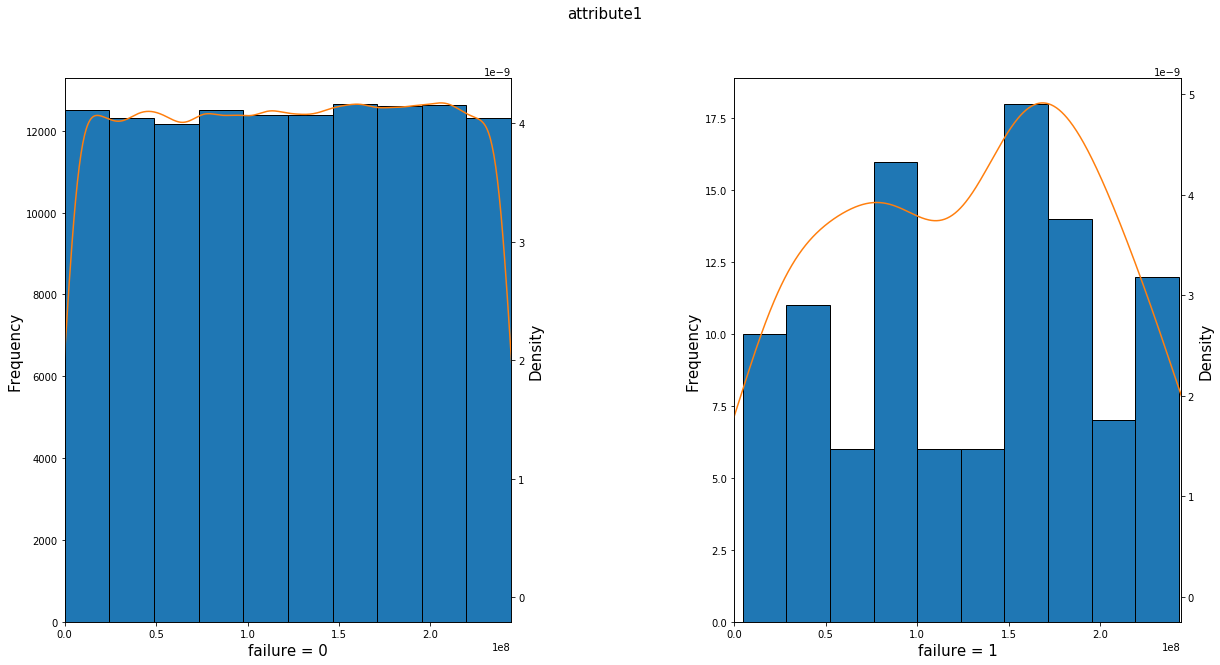

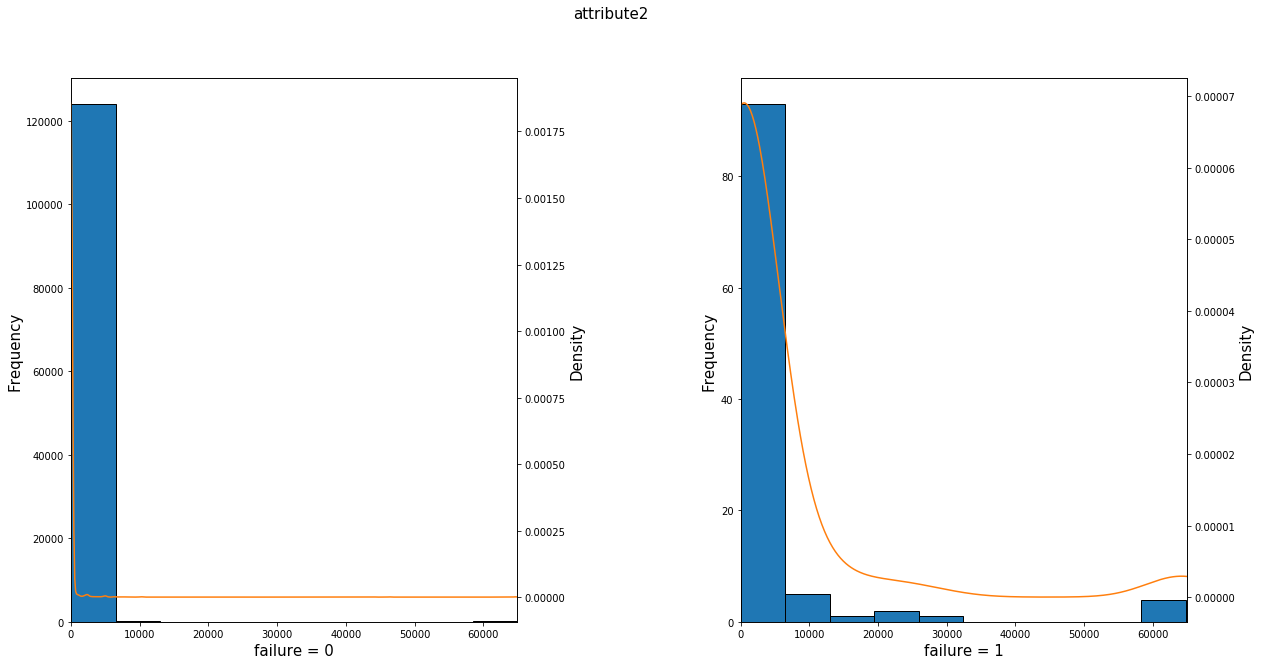

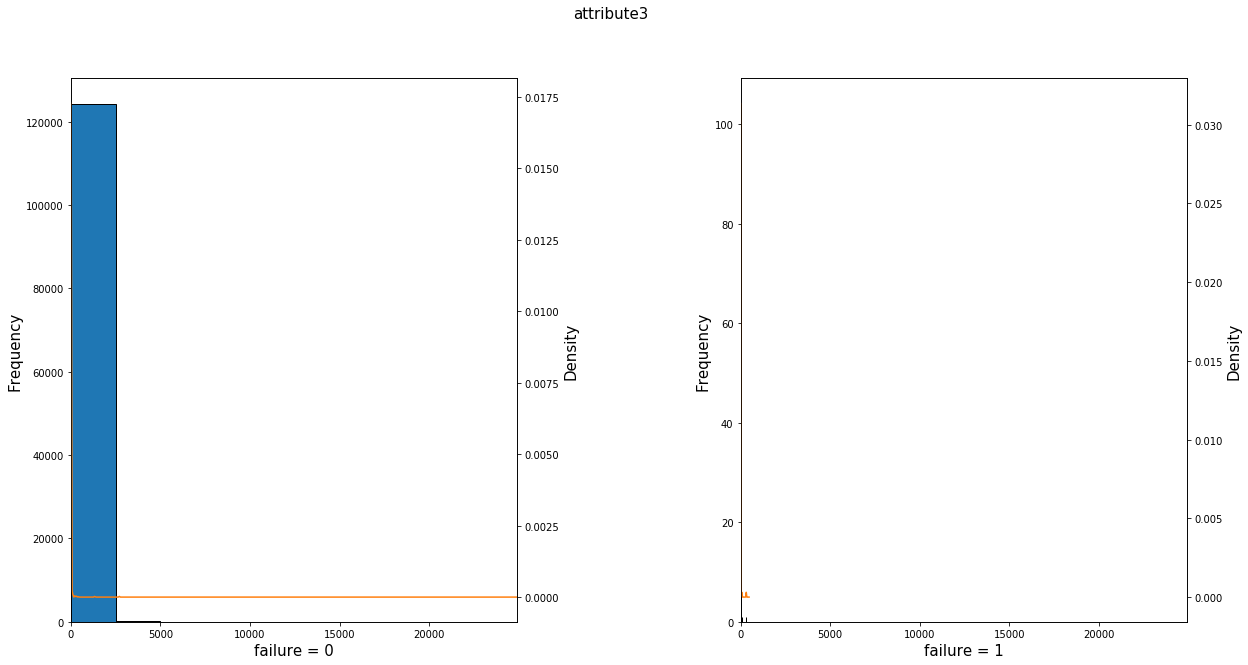

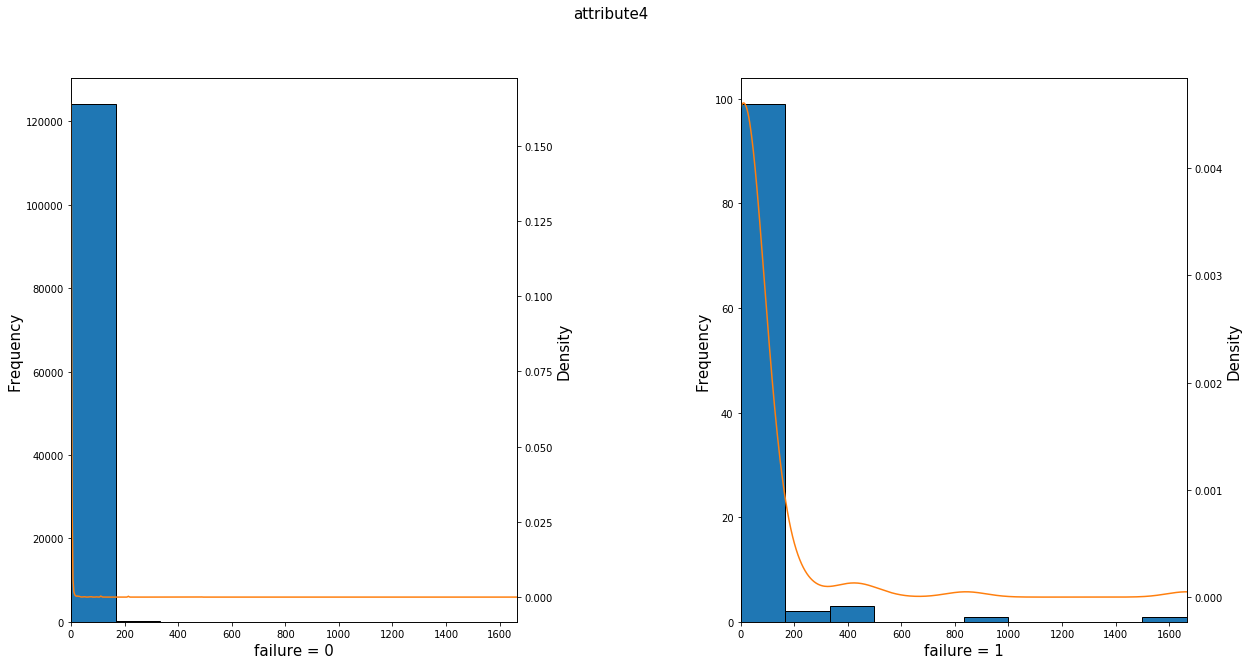

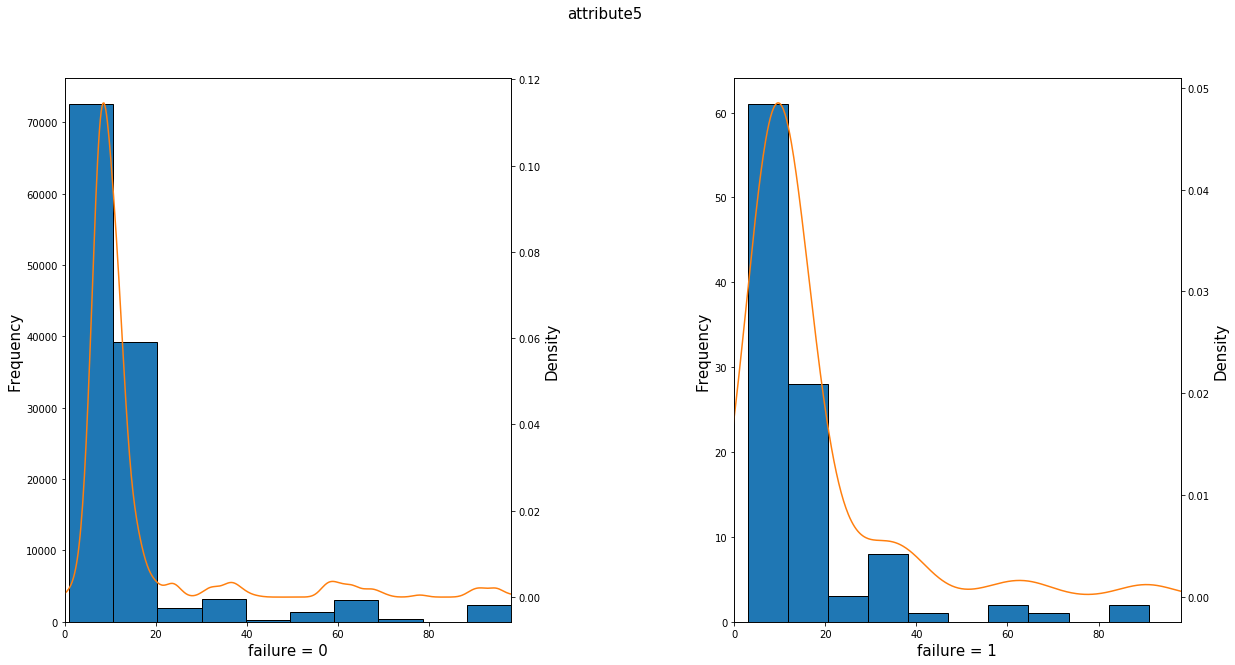

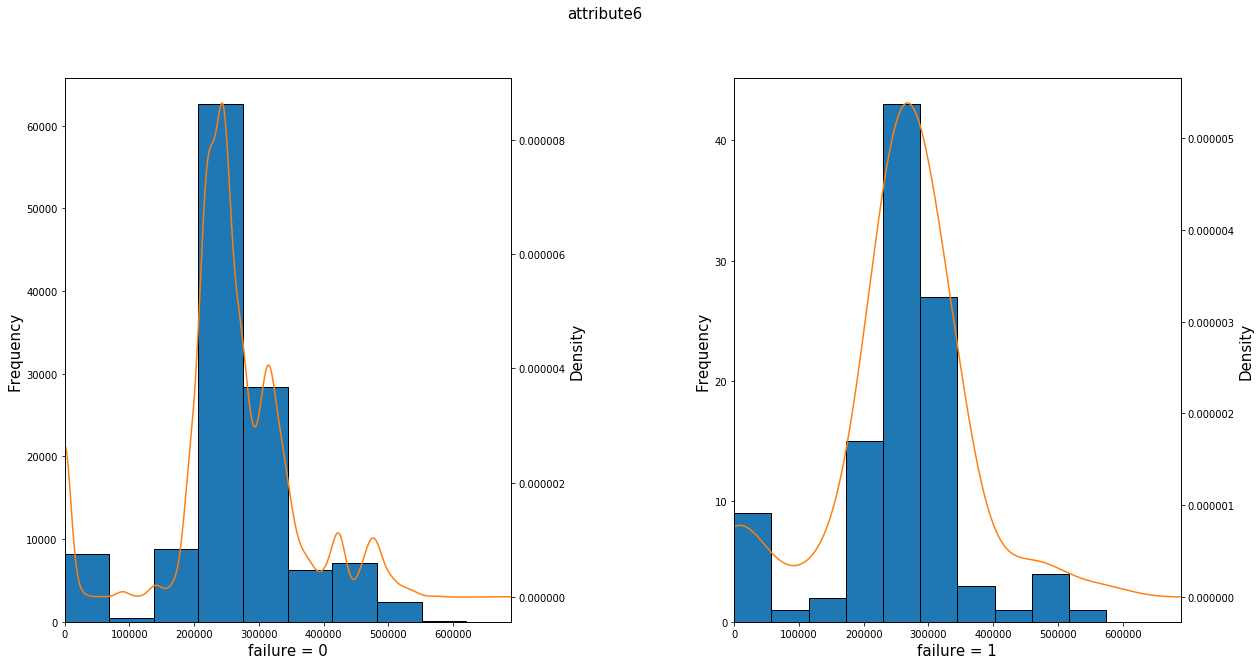

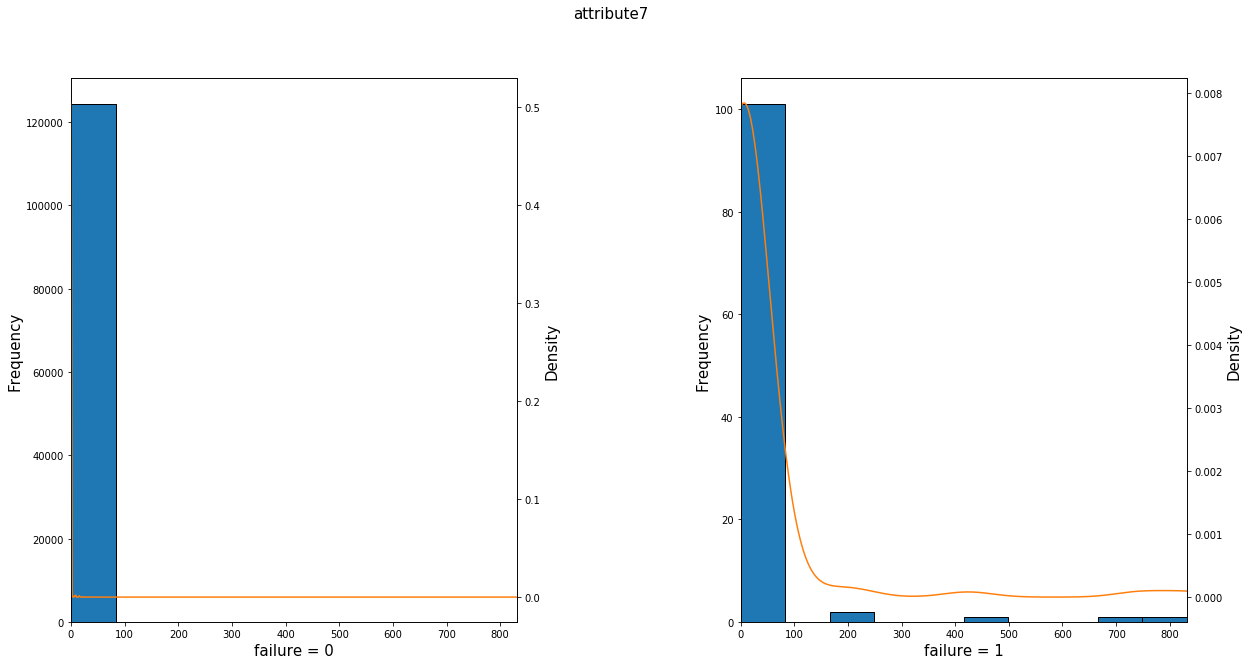

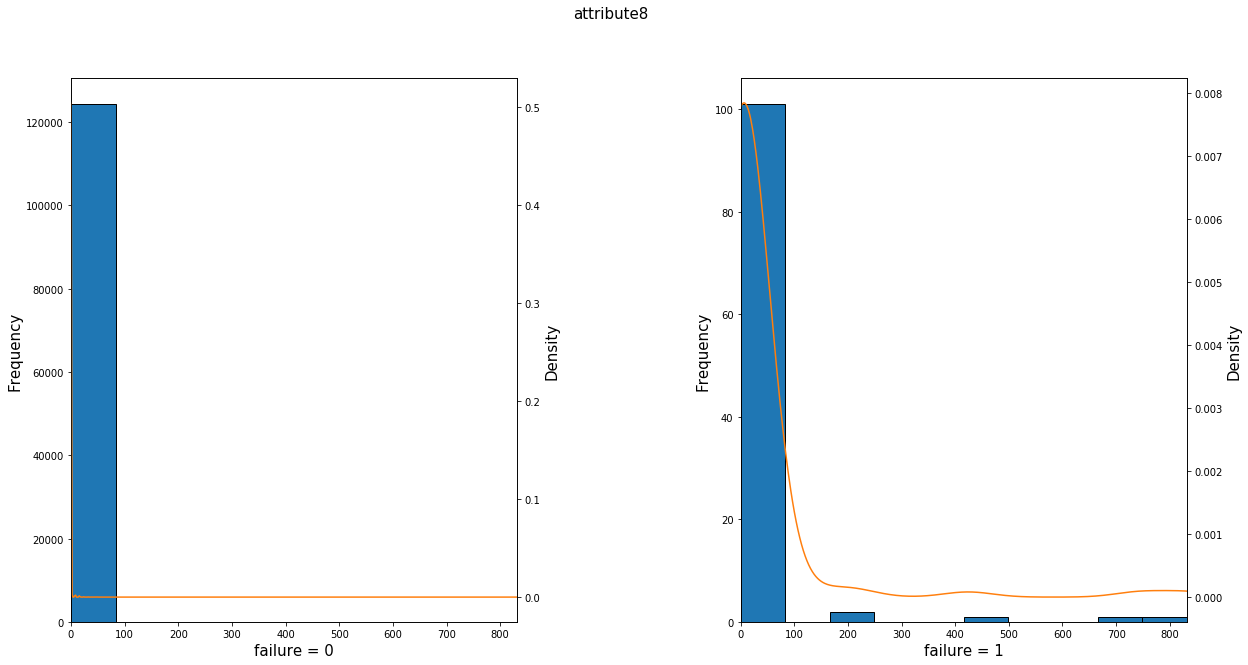

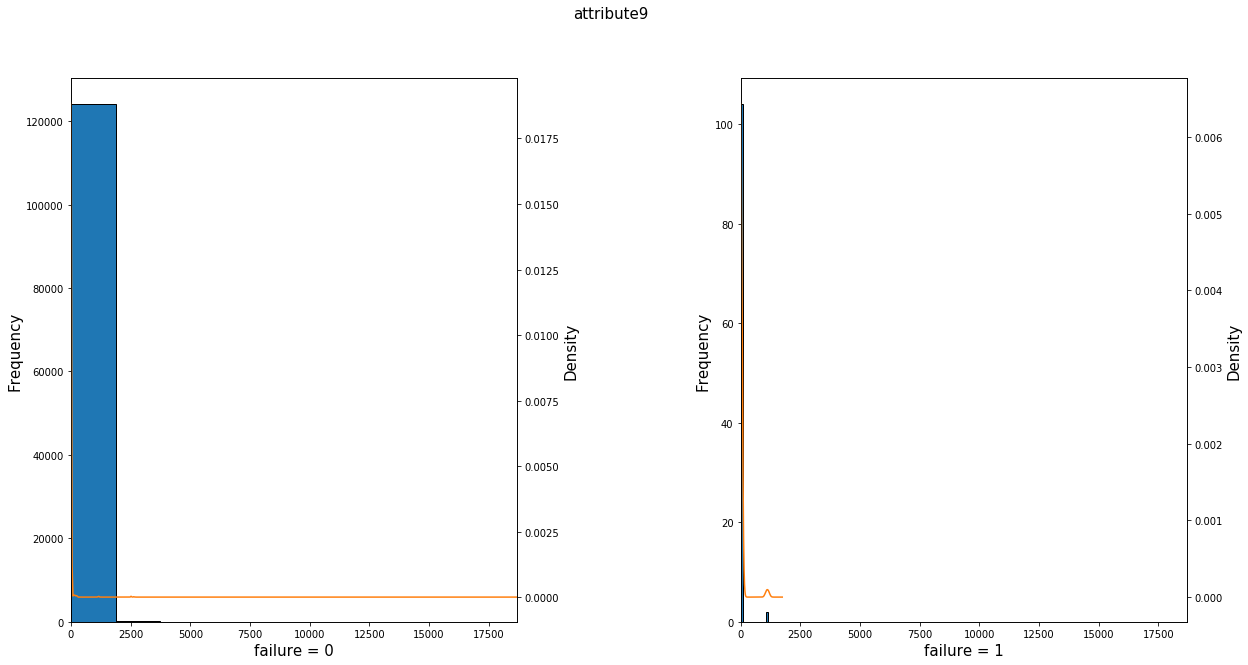

In [48]:
df_compare = explore_data(df)

### 1.3 Identify columns which are different for failure = 0 & failure = 1 classes. 
The individual attribute columns are tested using the Kolmogorov-Smirnov statistical test (KS-test) to determine if the empirical distribution of values are different for failure = 0 & failure = 1 classes.

The KS-test indicates four attributes (2, 4, 7, 8) have values that are statistically different for the two classes. The underlying distribution of these attribute columns can be considered different with 99% confidence (i.e. p-value < 0.01) for these two classes. This is also substantiated from the histograms plotted for these four attributes.

In [49]:
#-------------------------------------------------------------------------------
# Computes the statistical distance between two samples using the KS-test.
# This is used to determine if the distribution of the attribute columns are
# statistically different when failure = 0 and failure = 1.
#-------------------------------------------------------------------------------
def compute_statistical_distance_attributes(df):
    col_names = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']

    test_stats = []
    for attribute in col_names:
        s0 = df[ df['failure'] == 0 ][attribute]
        s1 = df[ df['failure'] == 1 ][attribute]
        compare = ks_2samp(s0, s1)
        test_stats.append([attribute, compare.statistic, compare.pvalue])
    df_names = ['attribute', 'KS statistic', 'p-value']
    df_compare = pd.DataFrame.from_records(test_stats, columns=df_names)
    return df_compare

In [50]:
df_compare = compute_statistical_distance_attributes(df)
print(df_compare[ df_compare['p-value'] < 0.01 ])

    attribute  KS statistic       p-value
1  attribute2      0.401893  1.155866e-15
3  attribute4      0.510333  5.374385e-25
6  attribute7      0.356621  2.007132e-12
7  attribute8      0.356621  2.007132e-12


## 2. Predictive Modelling 

### 2.1 Overview of Machine Learning & Outcomes

We explore the utility of supervised machine learning methods to model the data. As in any machine learning modelling process, we follow the below steps:
- Transform the input data as required (model dependant)
- Choose a specific combination of model hyperparameters and perform K-fold cross validation. More specifically, we apply __Stratified crossvalidation__ to ensure we have the same proportion of examples of the two classes in each of the training and testing subsets.
- Perform cross-validation (K times) so that in each of the K iterations, the model is _trained_ on (K-1) subsets of data and _tested_ on the remaining subset. 
- Choose a specific combination of the model hyperparameters and perform K-fold crossvalidation. The average performance across the K iterations is considered the performance of the chosen set of hyperparameters.

### a. Machine Learning models explored
The following supervised machine learning methods have been explored to investigate the problem
- _Decision Tree_
- _Neural Network_ 
- _Logistic Regression_ 
- _Random Forest_

### b. Model Evaluation Criteria
The binary classification problem presented here is interesting because we are interested in predicting the failure = 1 class more reliably. There are several evaluation metrics (Accuracy, Precision, Recall, AUC score) that one can employ to evaluate the model. However in this problem, we want to minimize the false positives & false negatives. This corresponds to maximizing the __AUC score__ in the ROC curve.

Furthermore, since the minority class (failure = 1) has a very small representative data, it could be to useful to explore __Recall__ as an alternative metric. Recall gives a measure of predicting the minority class reliably. Using other metrics such as Accuracy could be non-informative as majority of the data (> 99%) is representative of failure = 0 class and hence the model, by nature, learns to predict the majority class with a great degree of accuracy however its performance on predicting the minority class could be low.

### c. Results Summary
The below table summarizes the performance of the predictive models tested as part of this exercise. Detailed analysis described below.

| Predictive Model | AUC score | Recall |
| --- | --- | --- |
| Decision Tree (all attr) | 0.74 | 0.10 |
| Decision Tree (reduced attr) | 0.73 | 0.04 |
| Neural Network (reduced attr) | 0.86 | 0.00 |
| Logistic Regression (reduced attr) | 0.86 | 0.53 |
| __Random Forest (all attr)__ | __0.87__ | __0.70__ |
| __Random Forest (reduced attr)__ | __0.86__ | __0.71__ |


In [51]:
col_names = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']
state = 'all'  # all attributes
X = df[col_names]
y = df['failure']

### 2.2 Cross-validation and determination of optimal hyperparameters
- Setup cross validation parameters (Stratified)
- Specify the evaluation metrics to compare

In [52]:
crossvalidation = StratifiedKFold(n_splits = 3)
scoring_metrics = {
                    'Accuracy': 'accuracy',
                    'Recall': 'recall',
                    'Precision': 'precision',
                    'F1': 'f1',
                    'AUC': 'roc_auc'
                  }

Instantiate the machine learning model with a list of hyperparameters specific to that model type. The optimal hyperparameters are inferred as part of the K-Fold crossvalidation process. The defining hyperparameters are
- __Decision Tree:__ Height
- __Neural Network:__ number of hidden layers, number of nodes in each layer, activation function, learning rate, regularization, etc.
- __Logistic Regression:__ inverse regularization parameter
- __Random Forest:__ number of trees, max height of the trees 

In [53]:
#-------------------------------------------------------------------------------
# Instantiate the machine learning models with their respective parameters for
# cross-validation.
#-------------------------------------------------------------------------------
def instantiate(model_type):
    if model_type == 'Decision Tree':
        MAX_HEIGHT = 20
        model = DecisionTreeClassifier(random_state=0)
        model_parameter_grid = {
         'max_depth': range(1,(MAX_HEIGHT+1))
        }
    elif model_type == 'Neural Network':
        NUM_HIDDEN_LAYERS = 2
        NUM_HIDDEN_NODES_PER_LAYER = 4
        model = MLPClassifier(
                  solver='adam',
                  activation='logistic',
                  alpha=0.1,
                  learning_rate='adaptive',
                  shuffle=False,
                  random_state=0
                )
        model_parameter_grid = {
          #'activation': ['identity', 'logistic', 'tanh'],
          #'learning_rate': ['invscaling', 'adaptive'],
          #'alpha': [0.01, 0.1, 1.0],
          'hidden_layer_sizes': [x for x in itertools.product((range(1,(NUM_HIDDEN_NODES_PER_LAYER+1))), repeat=NUM_HIDDEN_LAYERS)]
        }
    elif model_type == 'Logistic Regression':
        model = LogisticRegression(
                    class_weight='balanced',
                    random_state=0
                )
        model_parameter_grid = {
            'C': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 2, 5, 10]
        }
    elif model_type == 'Random Forest':
        MAX_HEIGHT = 10
        NUM_TREES = 10
        model = RandomForestClassifier(random_state=0, class_weight='balanced')
        model_parameter_grid = {
          'max_depth': range(1,(MAX_HEIGHT+1)),
          'n_estimators': [x for x in range(1, (NUM_TREES+1))]
        }

    return model, model_parameter_grid

### 2.3 Decision Tree Analysis
We first investigate the utility of Decision Tree approach to construct a model to explain the two-class problem and fit the data to it using all 9 attributes. We will then see how the feature space can be reduced while achieving the same performance.

In [54]:
# Decision Tree
model_type = 'Decision Tree'
model, model_parameter_grid = instantiate(model_type)

__Model optimization:__ Iterating through all combinations of hyperparameters _(GridSearchCV)_ during the crossvalidation process. In the case of Decision Tree, we evaluate the suitability of all Decision Trees up to a height of 20 levels to assess their fit and ability to explain the data.

In [55]:
#-------------------------------------------------------------------------------
# Execute the cross-validation for all parameter combinations and plots the
# evaluation metrics. At each iteration of the cross validation process, the 
# model is evaluated using all the below metrics but the optimal model is 
# determined using the AUC score (as this minimizes both false positives &
# false negatives).
#-------------------------------------------------------------------------------
def build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics, state):
    grid_object = GridSearchCV(model, param_grid=model_parameter_grid, cv=crossvalidation, scoring=scoring_metrics, refit='AUC', return_train_score=True, n_jobs=-1)
    print('Performing grid search to determine the optimal parameters ...')
    grid_object.fit(X, y)
    grid_search_output = pd.DataFrame(grid_object.cv_results_)
    grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']]

    if model_type == 'Decision Tree':
        MAX_HEIGHT = 20
        plot_cross_validation_output(grid_search_output, scoring_metrics, MAX_HEIGHT, state)

    optimal_model = grid_object.best_estimator_
    optimal_model = optimal_model.fit(X, y)

    return grid_search_output, optimal_model


In [56]:
#-------------------------------------------------------------------------------
# Graphs the outputs of the cross-validation optimization process for the
# __Decision Tree__ model (this function can be extended to any model which has a
# single changeable hyperparameter).
#
# Produces comparison of the different evaluation metrics for
# training & testing data splits.
#-------------------------------------------------------------------------------
def plot_cross_validation_output(grid_search_output, scoring_metrics, max_height, state):
    fig = plt.figure()
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=12)

    plt.xlabel("DecisionTree Height")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xticks(np.linspace(0, max_height, max_height+1))
    ax.set_ylim(0, 1.05)

    # Set X-axis to be the Decision Tree height
    X_axis = np.array(grid_search_output['param_max_depth'], dtype=int)

    for scorer, color in zip(scoring_metrics, ['r', 'b', 'm', 'g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = grid_search_output['mean_%s_%s' % (sample, scorer)]
            sample_score_std = grid_search_output['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(grid_search_output['rank_test_%s' % scorer] == 1)[0][0]
        best_score = grid_search_output['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    #plt.legend(loc="best")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid('off')
    plt.show()

    results_dir = 'results/'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    filename = 'decision_tree_evaluation_' + state + '.png'
    filepath= os.path.join(results_dir, filename)
    fig.savefig(filepath, bbox_inches = 'tight')


__Optimal Model Selection__
We observe below the comparison plot of the various evaluation metrics. 
1. __AUC score__ is maximum when the Height of the Decision Tree = 7 (corresponding Recall is 0.10)
2. __Recall__ is maximum when Height = 12 (corresponding AUC score is 0.51)

Since AUC is a metric which is maximum when false positive rate & false negative rate are jointly minimum. We therefore select the _Decision Tree with height 7 as the optimal model_ in this case.

__Model Complexity vs Goodness-of-fit__
The comparison plot below also addresses the problem of balancing the model complexity and the goodness-of-fit to the data. This is also referred to as _Bias vs Variance trade-off_. The model complexity stems from the model's parameters (in this case, the height of the tree). The goodness-of-fit of the model to the data refers to how well the model can explain the underlying data. In this case, it is the value of the evaluation metric considered. 

We observe that during the _training_ phase, both AUC and Recall continuously improve with the increase in complexity (height) of the Decision Tree. However, during the _testing_ phase, both AUC and Recall steadily increase until a maximum is reached and then continuously drop. This occurs at heights of 7 & 12 for AUC & Recall respectively. Hence, by employing the crossvalidation process, we are able to infer the optimal model complexity for the the evaluation metrics considered. This is characteristic of the bias vs variance trade-off in statistical machine learning.

Performing grid search to determine the optimal parameters ...


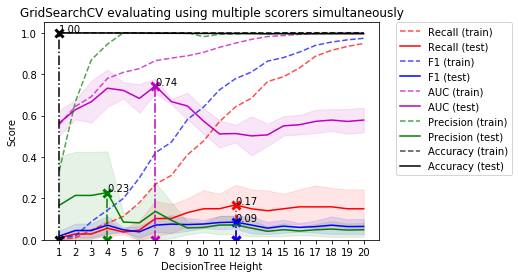

In [57]:
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics, state)

In [73]:
#pd.set_option('display.max_columns', 100)
grid_search_output

,mean_fit_time,mean_score_time,mean_test_AUC,mean_test_Accuracy,mean_test_F1,mean_test_Precision,mean_test_Recall,mean_train_AUC,mean_train_Accuracy,mean_train_F1,mean_train_Precision,mean_train_Recall,param_max_depth,params,rank_test_AUC,rank_test_Accuracy,rank_test_F1,rank_test_Precision,rank_test_Recall,split0_test_AUC,split0_test_Accuracy,split0_test_F1,split0_test_Precision,split0_test_Recall,split0_train_AUC,split0_train_Accuracy,split0_train_F1,split0_train_Precision,split0_train_Recall,split1_test_AUC,split1_test_Accuracy,split1_test_F1,split1_test_Precision,split1_test_Recall,split1_train_AUC,split1_train_Accuracy,split1_train_F1,split1_train_Precision,split1_train_Recall,split2_test_AUC,split2_test_Accuracy,split2_test_F1,split2_test_Precision,split2_test_Recall,split2_train_AUC,split2_train_Accuracy,split2_train_F1,split2_train_Precision,split2_train_Recall,std_fit_time,std_score_time,std_test_AUC,std_test_Accuracy,std_test_F1,std_test_Precision,std_test_Recall,std_train_AUC,std_train_Accuracy,std_train_F1,std_train_Precision,std_train_Recall
0,0.042264,0.032575,0.564433,0.999149,0.018018,0.166667,0.009524,0.556210,0.999153,0.009259,0.333333,0.004695,1,{u'max_depth': 1},14,1,20,4,20,0.651596,0.999133,0.000000,0.000000,0.000000,0.563460,0.999157,0.000000,0.000000,0.000000,0.514274,0.999157,0.054054,0.500000,0.028571,0.507042,0.999157,0.027778,1.000000,0.014085,0.527426,0.999157,0.000000,0.000000,0.000000,0.598127,0.999145,0.000000,0.000000,0.000000,0.002442,0.002882,0.061868,0.000011,0.025481,0.235702,0.013469,0.037537,0.000006,0.013095,0.471405,0.006640
1,0.063470,0.032335,0.628099,0.999068,0.044685,0.214287,0.028043,0.643812,0.999157,0.018649,0.666667,0.009457,2,{u'max_depth': 2},8,2,17,2,18,0.692298,0.998892,0.080000,0.142857,0.055556,0.619548,0.999169,0.028169,1.000000,0.014286,0.585232,0.999157,0.054054,0.500000,0.028571,0.597438,0.999157,0.027778,1.000000,0.014085,0.606764,0.999157,0.000000,0.000000,0.000000,0.714449,0.999145,0.000000,0.000000,0.000000,0.011159,0.004083,0.046240,0.000125,0.033325,0.210279,0.022684,0.050757,0.000010,0.013188,0.471405,0.006687
2,0.099012,0.043917,0.666756,0.999012,0.044685,0.214287,0.028043,0.691285,0.999181,0.087568,0.869048,0.047150,3,{u'max_depth': 3},6,3,17,2,18,0.808569,0.998892,0.080000,0.142857,0.055556,0.740637,0.999181,0.081081,0.750000,0.042857,0.585148,0.999157,0.054054,0.500000,0.028571,0.604559,0.999157,0.027778,1.000000,0.014085,0.606544,0.998988,0.000000,0.000000,0.000000,0.728660,0.999205,0.153846,0.857143,0.084507,0.001834,0.003313,0.100659,0.000110,0.033325,0.210279,0.022684,0.061519,0.000020,0.051671,0.102409,0.028910
3,0.106598,0.034467,0.732086,0.998755,0.070833,0.228051,0.056085,0.779019,0.999209,0.143274,0.944444,0.080013,4,{u'max_depth': 4},2,4,7,1,15,0.842713,0.998699,0.129032,0.153846,0.111111,0.809565,0.999193,0.082192,1.000000,0.042857,0.732811,0.999157,0.054054,0.500000,0.028571,0.770970,0.999193,0.106667,1.000000,0.056338,0.620729,0.998410,0.029412,0.030303,0.028571,0.756521,0.999241,0.240964,0.833333,0.140845,0.007933,0.004649,0.090626,0.000308,0.042365,0.198801,0.038910,0.022390,0.000023,0.069796,0.078567,0.043365
4,0.128049,0.031965,0.721442,0.998739,0.048148,0.085644,0.037566,0.808655,0.999245,0.199666,1.000000,0.113078,5,{u'max_depth': 5},3,5,16,7,17,0.775039,0.998578,0.063492,0.074074,0.055556,0.825578,0.999229,0.157895,1.000000,0.085714,0.704519,0.999036,0.047619,0.142857,0.028571,0.779048,0.999205,0.131579,1.000000,0.070423,0.684765,0.998602,0.033333,0.040000,0.028571,0.821339,0.999301,0.309524,1.000000,0.183099,0.016356,0.004443,0.038748,0.000210,0.012318,0.042781,0.012721,0.021007,0.000041,0.078421,0.000000,0.049904
5,0.174638,0.038087,0.682852,0.998321,0.038347,0.081993,0.046562,0.826497,0.999301,0.299078,1.000000,0.179276,6,{u'max_depth': 6},4,6,19,8,16,0.769839,0.997229,0.065041,0.045977,0.111111,0.854542,0.999313,0.313253,1.000000,0.185714,0.677541,0.999084,0.050000,0.200000,0.028571,0.794539,0.999229,0.179487,1.000000,0.098592,0.601170

In [62]:
optimal_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [63]:
grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy', 'rank_test_Accuracy']]

,params,mean_test_AUC,rank_test_AUC,mean_test_Recall,rank_test_Recall,mean_test_Precision,mean_test_Accuracy,rank_test_Accuracy
0,{u'max_depth': 1},0.564433,14,0.009524,20,0.166667,0.999149,1
1,{u'max_depth': 2},0.628099,8,0.028043,18,0.214287,0.999068,2
2,{u'max_depth': 3},0.666756,6,0.028043,18,0.214287,0.999012,3
3,{u'max_depth': 4},0.732086,2,0.056085,15,0.228051,0.998755,4
4,{u'max_depth': 5},0.721442,3,0.037566,17,0.085644,0.998739,5
5,{u'max_depth': 6},0.682852,4,0.046562,16,0.081993,0.998321,6
6,{u'max_depth': 7},0.742556,1,0.102647,14,0.137298,0.997775,7
7,{u'max_depth': 8},0.667072,5,0.102911,13,0.094425,0.997590,8
8,{u'max_depth': 9},0.646203,7,0.131218,12,0.057051,0.997068,9
9,{u'max_depth': 10},0.573615,11,0.149737,10,0.059854,0.996964,10


In [72]:
#-------------------------------------------------------------------------------
# Classification and ROC analysis
#-------------------------------------------------------------------------------
# Run classifier with cross-validation and plot ROC curves
def classification_roc_analysis(cv, X, y, classifier, model_type):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        if model_type == 'Neural Network':
            probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        else:
            probas_ = classifier.fit(X.iloc[train], y[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

(array([0.        , 0.00301474, 0.00315944, 0.00318356, 0.00373827,
       0.00882715, 0.00940598, 0.01008128, 0.01410896, 0.02626438,
       0.04483515, 0.04917637, 0.0783349 , 0.96445023, 1.        ]), array([0.        , 0.19444444, 0.25      , 0.25      , 0.38888889,
       0.44444444, 0.44444444, 0.44444444, 0.47222222, 0.47222222,
       0.58333333, 0.58333333, 0.63888889, 0.83333333, 1.        ]))
(array([0.00000000e+00, 1.44707329e-04, 1.92943106e-04, 4.34121988e-04,
       5.78829318e-04, 4.00356945e-03, 5.76417529e-03, 6.63241927e-03,
       2.40214167e-02, 5.54952608e-02, 9.98577045e-01, 1.00000000e+00]), array([0.        , 0.08571429, 0.08571429, 0.08571429, 0.14285714,
       0.25714286, 0.31428571, 0.31428571, 0.42857143, 0.6       ,
       0.94285714, 1.        ]))
(array([0.00000000e+00, 9.40620327e-04, 1.06121268e-03, 1.44710820e-03,
       1.34581062e-02, 3.00274951e-02, 4.68863055e-02, 9.97057547e-01,
       1.00000000e+00]), array([0.        , 0.02857143, 0.02857143,

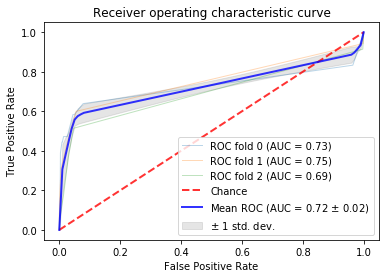

In [71]:
classifier = DecisionTreeClassifier(max_depth=7)
classification_roc_analysis(crossvalidation, X, y, classifier, model_type)

__Prediction probabilities using the optimal model__ (first column corresponds to failure = 0)

In [74]:
print(optimal_model.predict_proba(X))

[[9.93322859e-01 6.67714061e-03]
 [9.99801473e-01 1.98527288e-04]
 [9.99801473e-01 1.98527288e-04]
 ...
 [9.97163121e-01 2.83687943e-03]
 [9.99801473e-01 1.98527288e-04]
 [9.99801473e-01 1.98527288e-04]]


In [16]:
#-------------------------------------------------------------------------------
# Postprocessing the optimal machine learning model to print out the Tree.
#-------------------------------------------------------------------------------
def post_process(model_type, optimal_model, state):
    if model_type == 'Decision Tree':
        # Print the optimal decision tree (takes time to output if the tree is lengthy)
        outfile = 'tree_' + state
        outfile_path = os.path.join('results', outfile)
        print('Exporting the optimal Decision Tree to %s ...' % outfile_path)
        dot_data = export_graphviz(optimal_model, out_file=None, feature_names=X.columns, rounded=True)
        graph = graphviz.Source(dot_data)
        graph.render(outfile_path)


In [83]:
post_process(model_type, optimal_model, state)

Exporting the optimal Decision Tree to results\tree_all ...


__Optimal Decision Tree that minimizes FPR & FNR__ (maximum AUC score): height 7
it is interesting to note that, in this tree, the top-level nodes are majorly comprised of attributes 2, 4, 7, 8. These are not surprisingly, identified as distinguishing attributes in the statistical analysis done previously using the KS-test. See tree below.

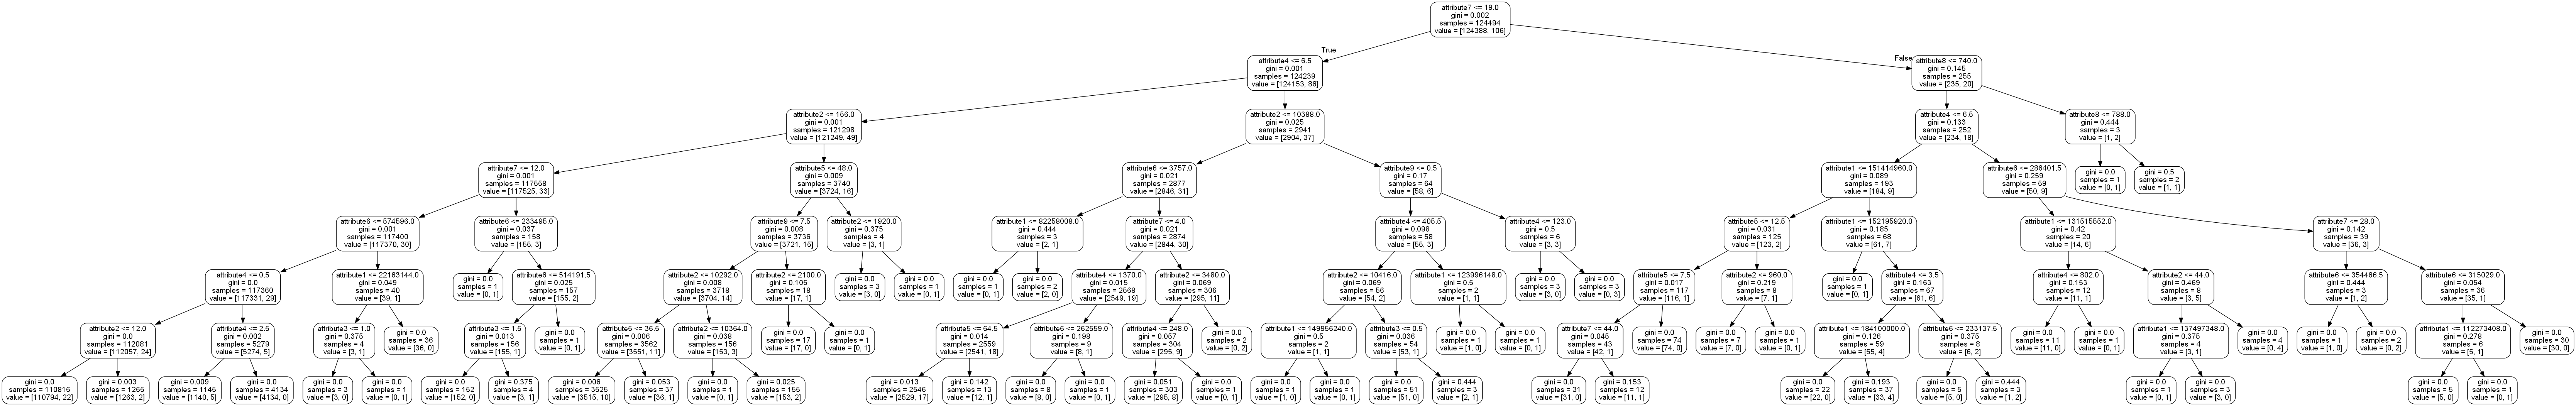

__Optimal Decision Tree that minimizes only FNR__ (maximum Recall): height 12. See tree below.

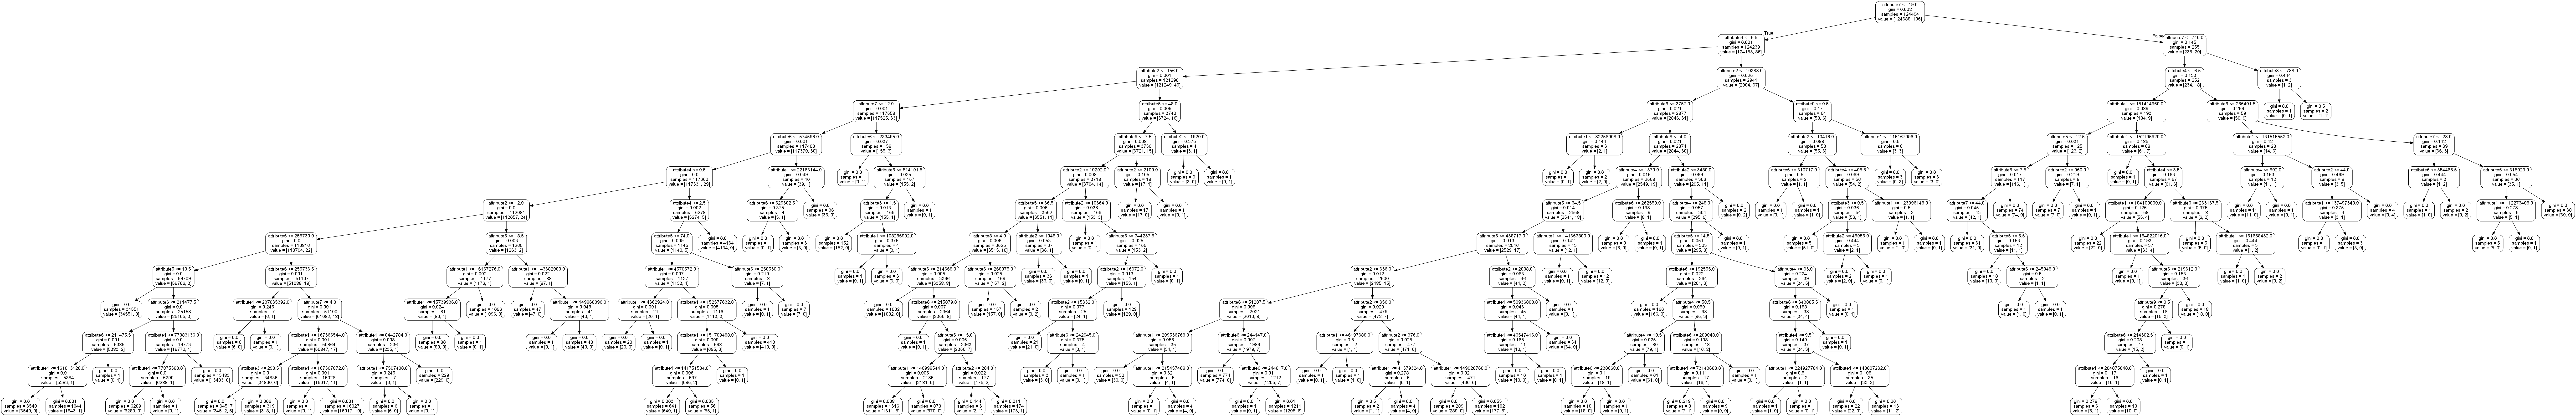

### 2.4 Rebuilding the Decision Tree using a reduced set of attributes
As discussed above, we will use only the four differenting attributes (2, 4, 7, 8) and compare the final tree generated and the optimal model inferred. Repeating the sequence of steps as above...

In this case, interestingly, we obtain a smaller tree of height 4. However, the AUC score is 0.73 (previously 0.74), so we achieve the same performance but with a reduced model complexity. The smaller tree is relatively easier to comprehend as compared to the previous tree of height 7. The tree is shown below.

Performing grid search to determine the optimal parameters ...


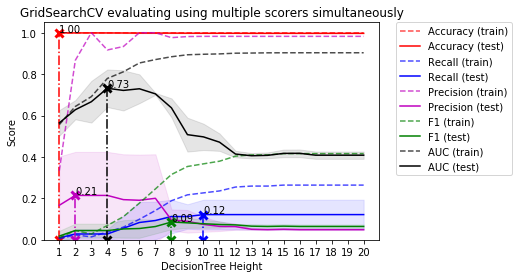

In [84]:
col_names = ['attribute2', 'attribute4', 'attribute7', 'attribute8']
state = 'reduced'  # reduced list of attributes
X = df[col_names]
y = df['failure']
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics, state)

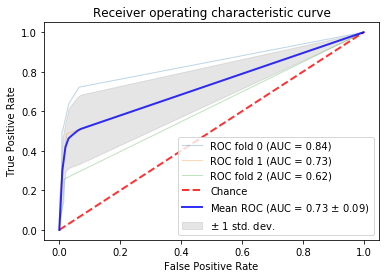

In [85]:
classifier = DecisionTreeClassifier(max_depth=4)
classification_roc_analysis(crossvalidation, X, y, classifier, model_type)

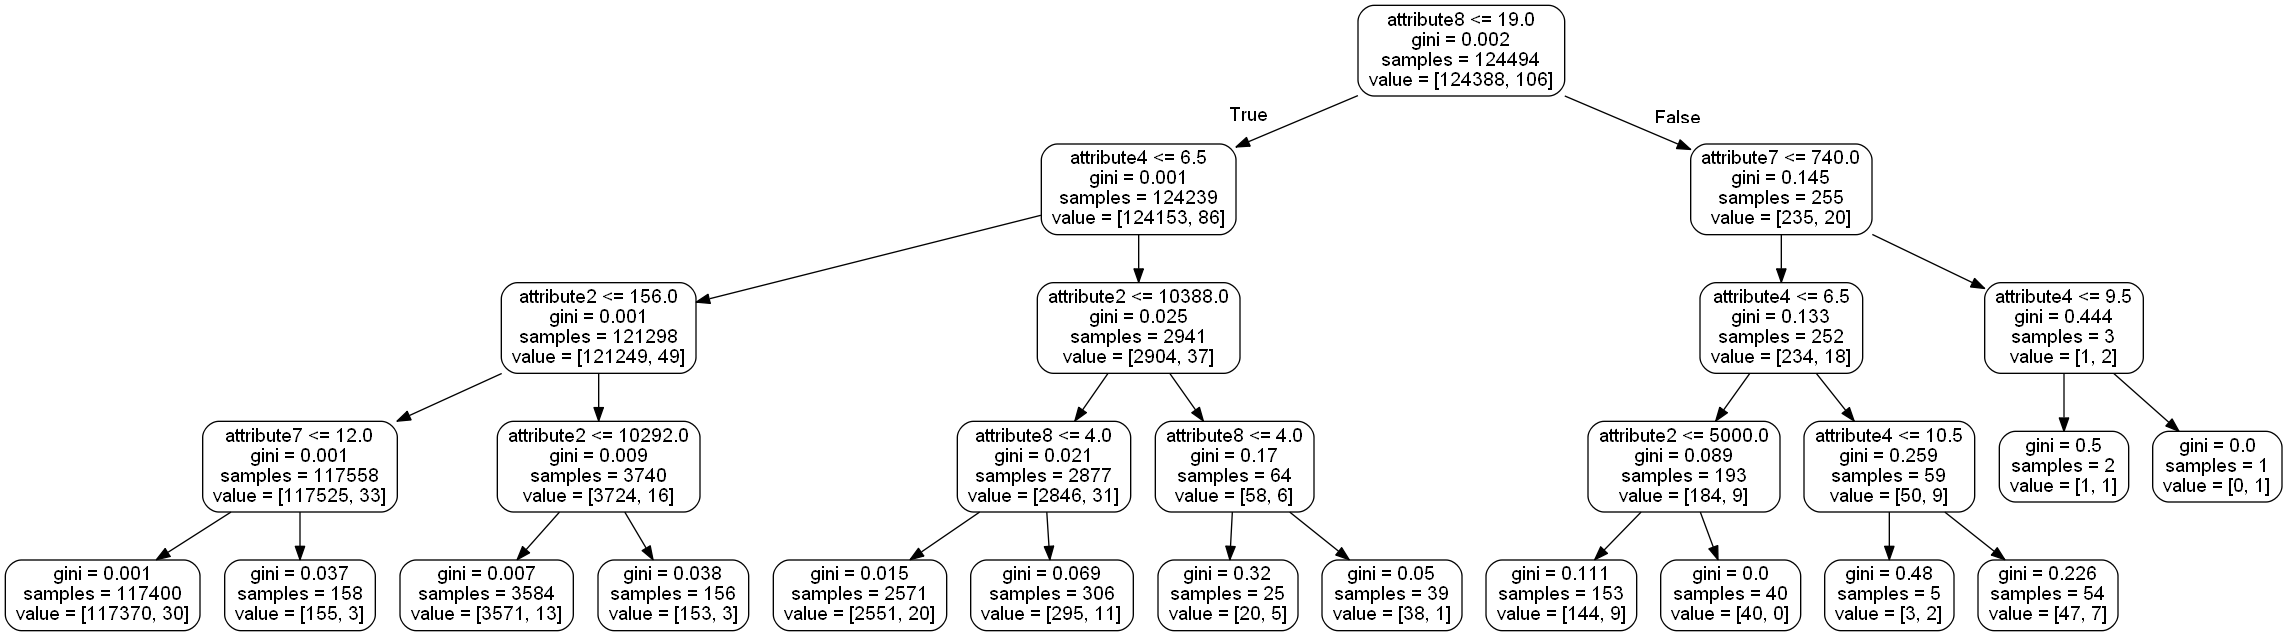

### 2.5 Neural Network Modelling
In the following analysis, we investigate the utility of _Neural Network_ based predictive modelling. We use the above four attribute columns to perform the modelling. Determining the optimal hyperparameters is achieved using K-Fold cross validation as before. Note that unlike the Decision Tree approach, the input data for a Neural Network needs to be scaled prior to modelling.

__Analysis__: The results of the modelling demonstrate that for this data, an optimal neural network would have two hidden layers with 2 & 4 hidden nodes in them respectively. Note that for demonstration, I have only modified the hyperparameters related to the hidden nodes. Other hyperparameters such as activation function, learning rate, regularization, etc can be trialled however they become computationally expensive.

In [86]:
# normalize the data prior to Neural Network modelling
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# cross-validation to infer optimal parameters
model_type = 'Neural Network'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X_scaled, y, crossvalidation, scoring_metrics, state)
print(grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']])

Performing grid search to determine the optimal parameters ...
                            params  mean_test_AUC  rank_test_AUC  mean_test_Recall  rank_test_Recall  mean_test_Accuracy  rank_test_Accuracy
0   {'hidden_layer_sizes': (1, 1)}       0.427036             16               0.0                 1            0.999149                   1
1   {'hidden_layer_sizes': (1, 2)}       0.652071             15               0.0                 1            0.999149                   1
2   {'hidden_layer_sizes': (1, 3)}       0.865123              2               0.0                 1            0.999149                   1
3   {'hidden_layer_sizes': (1, 4)}       0.864624              8               0.0                 1            0.999149                   1
4   {'hidden_layer_sizes': (2, 1)}       0.850449              9               0.0                 1            0.999149                   1
5   {'hidden_layer_sizes': (2, 2)}       0.864654              7               0.0         

__Optimal hidden layers and Model evaluation__: From the resultant grid search for the optimal hyperparameters, we observe that for the hidden_layer_sizes=(2,4) combination, we obtain the best AUC score during the testing phase. The AUC score is 0.86 which is greater than what was observed for the Decision Tree (0.73). However, the corresponding Recall value for the Neural network is 0 which limits its utility. 

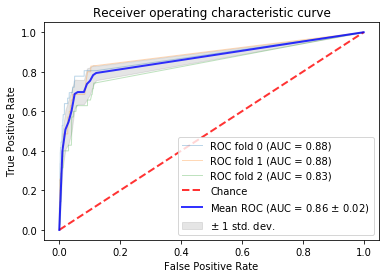

In [88]:
classifier = MLPClassifier(
          solver='adam',
          activation='logistic',
          alpha=0.1,
          learning_rate='adaptive',
          shuffle=False,
          random_state=0,
          hidden_layer_sizes=(2, 4)  # determined using cross validation above
        )
classification_roc_analysis(crossvalidation, X_scaled, y, classifier, model_type)

### 2.6 Logistic Regression
In the following analysis, we investigate the utility of __Logistic Regression__ based predictive modelling. We use the above four attribute columns to perform the modelling. There is a single hyperparameter (C: inverse regularization) that needs to be tuned and is achieved using K-Fold cross validation as before. Note that the input data for a Logistic Regression model need not to be scaled prior to modelling.

__Analysis__: The results of the modelling demonstrate that for this data, an optimal Logistic Regression model is inferred when C = 0.03.

__Model Evaluation__: We observe the modelling results in a maximum AUC test score of 0.86 which is comparable to that of a Neural network model. The corresponding Recall value is 0.53 which is significantly higher to what we achieved using Decision Tree & Neural Network models. Hence, thus far, the Logistic Regression model has outperformed the other two methods investigated here.

In [92]:
col_names = ['attribute2', 'attribute4', 'attribute7', 'attribute8']
state = 'reduced'  # reduced list of attributes
X = df[col_names]
y = df['failure']

model_type = 'Logistic Regression'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics, state)
print(grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']])

Performing grid search to determine the optimal parameters ...
          params  mean_test_AUC  rank_test_AUC  mean_test_Recall  rank_test_Recall  mean_test_Accuracy  rank_test_Accuracy
0   {'C': 0.001}       0.863993             10          0.536246                 1            0.967966                  13
1   {'C': 0.003}       0.863992             11          0.536246                 1            0.968496                  12
2   {'C': 0.005}       0.863992             13          0.536246                 1            0.968649                  11
3    {'C': 0.01}       0.863992             12          0.536246                 1            0.968657                  10
4    {'C': 0.03}       0.864016              1          0.536246                 1            0.968673                   1
5    {'C': 0.05}       0.864016              1          0.536246                 1            0.968673                   1
6     {'C': 0.1}       0.864016              3          0.536246            

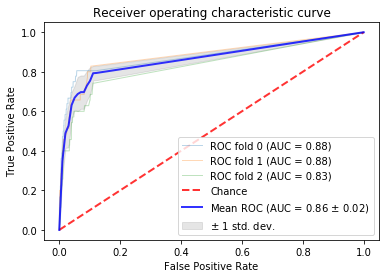

In [95]:
classifier = LogisticRegression(
            class_weight='balanced',
            random_state=0,
            C=0.03
        )
classification_roc_analysis(crossvalidation, X, y, classifier, model_type)

### 2.7 Random Forest Classifier
In the following analysis, we investigate the utility of __Random Forest__ based predictive modelling. We experiment two scenarios:
1. using all 9 attributes
2. using the previously chosen reduced set of 4 attributes

The reason to consider the above two scenarios in this case is to demonstrate the ability of the Random Forest classifier to determine the _importance_ of each attribute. We will see below how this aligns with our analysis thus far.

There are two main hyperparameters (number of trees, max height) that need to be tuned and is achieved using K-Fold cross validation as before. Note that the input data for a Random Forest model need not to be scaled prior to modelling.

__Random Forest Classification Analysis__
The results of the modelling demonstrate very favourable outcomes. We iterated through 100 combinations of hyperparameters (NTREES = {1,...,10} and MAX_HEIGHT = {1,...,10}). Shown below are the top 15 ranked combinations.

1. _All attributes:_ In this case, we observe the hyperparameter combination {'max_depth': 4, 'n_estimators': 10} to have a high AUC pf 0.87 and a recall of 0.57. The combination {'max_depth': 3, 'n_estimators': 9} ranked 3 with respect to AUC has an AUC of 0.868 and a high recall of 0.69. This is clearly better than the machine learning models we have explored so far.

2. _Reduced set of four attributes:_ In this case, we observe the combination {'max_depth': 2, 'n_estimators': 7} to have a high AUC of 0.86 and a high recall of 0.70. This is far more superior than the results we have achieved so far.

In [101]:
col_names = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']
state = 'all'  # all attributes
X = df[col_names]
y = df['failure']

# Random Forest
model_type = 'Random Forest'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics, state)

ans = grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']]
print(ans[ ans['rank_test_AUC'] <= 15])

Performing grid search to determine the optimal parameters ...
                                  params  mean_test_AUC  rank_test_AUC  mean_test_Recall  rank_test_Recall  mean_test_Accuracy  rank_test_Accuracy
5    {'max_depth': 1, 'n_estimators': 6}       0.855341             15          0.518784                29            0.975043                  39
6    {'max_depth': 1, 'n_estimators': 7}       0.859340             10          0.612436                 8            0.961259                  59
7    {'max_depth': 1, 'n_estimators': 8}       0.859522              9          0.583865                14            0.966545                  49
8    {'max_depth': 1, 'n_estimators': 9}       0.859533              8          0.545769                26            0.974521                  40
9   {'max_depth': 1, 'n_estimators': 10}       0.859605              7          0.602119                11            0.950568                  78
17   {'max_depth': 2, 'n_estimators': 8}       0.856335

We also observe that the Random Forest classifier is able to determine the exact four attributes (2, 4, 7, 8) to be more important from the list of nine attributes. This outcome aligns with the statistical analysis done using the KS-test to identify these differentiating attributes as better predictors.

In [103]:
print(optimal_model.feature_importances_) # note the attributes 2, 4, 7, 8 have greater weights

[0.04262021 0.25985264 0.0057177  0.31817168 0.0094165  0.08154207
 0.20842426 0.06587478 0.00838015]


In [13]:
col_names = [ 'attribute2', 'attribute4', 'attribute7', 'attribute8',]
state = 'all'  # all attributes
X = df[col_names]
y = df['failure']

# Random Forest
model_type = 'Random Forest'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics, state)

ans = grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']]
print(ans[ ans['rank_test_AUC'] <= 15])

Performing grid search to determine the optimal parameters ...
                                  params  mean_test_AUC  rank_test_AUC  mean_test_Recall  rank_test_Recall  mean_test_Accuracy  rank_test_Accuracy
13   {'max_depth': 2, 'n_estimators': 4}       0.855393             14          0.754234                 3            0.896654                  96
14   {'max_depth': 2, 'n_estimators': 5}       0.859607              4          0.735187                 7            0.910526                  78
15   {'max_depth': 2, 'n_estimators': 6}       0.860644              2          0.735187                 7            0.910526                  78
16   {'max_depth': 2, 'n_estimators': 7}       0.860644              1          0.706615                14            0.906919                  90
17   {'max_depth': 2, 'n_estimators': 8}       0.859786              3          0.735187                 7            0.900670                  94
18   {'max_depth': 2, 'n_estimators': 9}       0.859260

In [14]:
print(optimal_model.feature_importances_)

[0.32209617 0.37499343 0.02907657 0.27383383]


## 3. Modelling Imbalanced Data

### 3.1 Oversampling the minority class (failure = 1)

In the following analysis, we investigate the utility of the above explored machine learning methods but taking into consideration the data is imbalanced. The skewness in data is due to the minority class (failure = 1) being less than 0.085% of the entire data. In this section, we will explore the utility of an oversampling technique which aims to emulate data as if it were coming from the distribution of the minority class. The new dataset will consist of data points belonging equally to the majority and minority classes. We _oversample_ the minority class in an effort to artificially boost its representation in the entire dataset.

We create a new dataset using an oversampling method called SMOTE (Synthetic Minority Oversampling Technique) such the failure = 1 class is represented equally as the failure = 0 class.

In [34]:
infile = 'device_failure.csv'
df = pd.read_csv(infile, header='infer', encoding = 'latin-1', dtype={'device':'str'})
df['date'] = pd.to_datetime(df['date'])
df['device'] = df['device'].astype('str')

In [35]:
# Oversampling the failure = 1 class using SMPOTE method
def oversample(X, y):
    # apply SMOTE
    method = SMOTE(kind='regular')
    X_res, y_res = method.fit_sample(X, y)

    X = pd.DataFrame(X_res)
    y = y_res
    return X, y

In [36]:
col_names = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']
state = 'all'
X = df[col_names]
y = df['failure']
Xnew, ynew = oversample(X, y)   # minority class (failure = 1) has been oversampled in the new dataset
Xnew.columns = col_names

In [37]:
def plot_resampling(ax, X, y, title):
    c0 = ax.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, s=2)
    c1 = ax.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, s=2)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    return c0, c1

In [38]:
# To compare the given and oversampled datasets, we perform a PCA and project the data
# into the two directions of maximum variance. This is done before and after sampling
# from the minority class. THe resulting projections are then plotted to see the difference.
def plot_smote(X, y, Xnew, ynew):
    # 2D PCA projection of the given data
    pca = PCA(n_components = 2) 
    X_vis = pca.fit_transform(X)
    
    # 2D PCA projection of the data with oversampled minority class
    X_res_vis = pca.transform(Xnew)
    
    # generate comparison data plots
    f, (ax1, ax2) = plt.subplots(1, 2)
    c0, c1 = plot_resampling(ax1, X_vis, y, 'Original')
    plot_resampling(ax2, X_res_vis, ynew, 'SMOTE')
    ax1.legend((c0, c1), ('Class #0', 'Class #1'))
    plt.tight_layout()
    plt.show()

__SMOTE data visualization__: We observe below that on the left is the actual data. On the right is the oversampled data. Clearly the minority class (in orange) has greate number of points on the right graph. This is because of the application of SMOTE to the data on the left. We can clearly see the overrepresentation of the minority class in the right plot as compared to the left one.

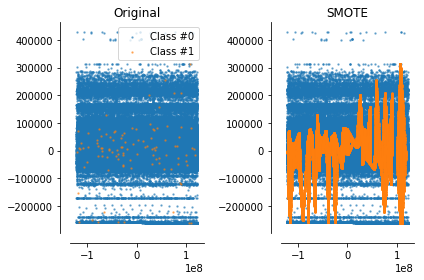

In [10]:
plot_smote(X, y, Xnew, ynew)

### 3.2 Decision Tree modelling of the Oversampled minority class (failure = 1)

### a. including all attribute columns
We now model the oversampled data using the Decision Tree method. In this instance, we use all the nine attribute columns. We determine the optimal paramters using cross validation as previously. We evaluate the performance of the model using the AUC and Recall metrics primarily.

Using AUC as the evaluation criterion, we observe from the plots below that a tree with height 10 is inferred as the optimal tree for this problem setup. Further investigation of the grid search results demonstate that when {'max_depth': 10}, the model is top ranked with an AUC score of 0.989 and a Recall of 0.985 respectively. This is a significant improvement to both the metrics as compared to the Decision Tree modelled on the actual provided data without oversampling the minority class.

Performing grid search to determine the optimal parameters ...


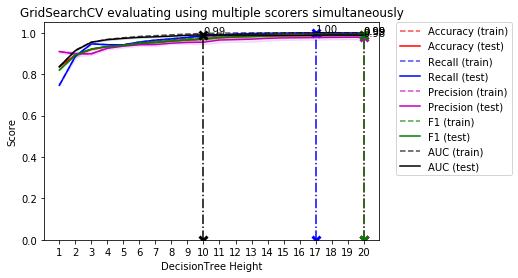

               params  mean_test_AUC  rank_test_AUC  mean_test_Recall  rank_test_Recall  mean_test_Accuracy  rank_test_Accuracy
0    {'max_depth': 1}       0.835647             20          0.745868                20            0.835647                  20
1    {'max_depth': 2}       0.913619             19          0.885737                19            0.891766                  19
2    {'max_depth': 3}       0.954072             18          0.946016                16            0.919522                  18
3    {'max_depth': 4}       0.966417             17          0.942205                17            0.932698                  17
4    {'max_depth': 5}       0.972649             16          0.941602                18            0.938197                  16
5    {'max_depth': 6}       0.977650             15          0.955036                15            0.947909                  15
6    {'max_depth': 7}       0.980297             14          0.964161                14            0.952

In [19]:
# Decision Tree
model_type = 'Decision Tree'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, Xnew, ynew, crossvalidation, scoring_metrics, state)
print(grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']]
)
#print(optimal_model.predict_proba(X))

#### AUC after oversampling the minority class is 0.99 which demonstrates the model is now able to accurately and reliably predict the minority class as well.

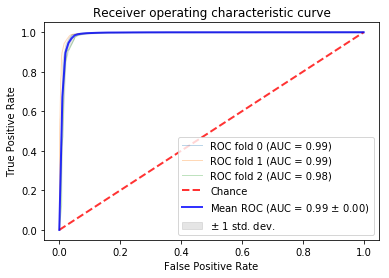

In [20]:
#post_process(model_type, optimal_model, state)
classifier = DecisionTreeClassifier(max_depth=10)
classification_roc_analysis(crossvalidation, Xnew, ynew, classifier, model_type)

### b. including only the reduced attribute columns
By including only the four differentiating attributes, we observe a slight decrease in AUC as compared to the one above. The top-ranked Decision Tree has a height of 7 and the corresponding AUC & Recall values are 0.96 and 0.938 respectively (also corroborated by the ROC curve below).

Performing grid search to determine the optimal parameters ...


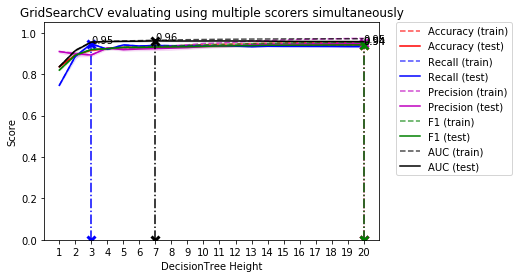

               params  mean_test_AUC  rank_test_AUC  mean_test_Recall  rank_test_Recall  mean_test_Accuracy  rank_test_Accuracy
0    {'max_depth': 1}       0.835647             20          0.745868                20            0.835647                  20
1    {'max_depth': 2}       0.913619             19          0.885737                19            0.891766                  19
2    {'max_depth': 3}       0.954566             18          0.946546                 1            0.916246                  18
3    {'max_depth': 4}       0.957433             15          0.919783                18            0.923272                  17
4    {'max_depth': 5}       0.958392             11          0.940790                 2            0.928233                  15
5    {'max_depth': 6}       0.959021              9          0.935958                 7            0.927891                  16
6    {'max_depth': 7}       0.960406              1          0.938483                 3            0.930

In [21]:
col_names = ['attribute2', 'attribute4', 'attribute7', 'attribute8']
state = 'reduced'
Xnew = Xnew[col_names]

model_type = 'Decision Tree'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, Xnew, ynew, crossvalidation, scoring_metrics, state)
print(grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']]
)

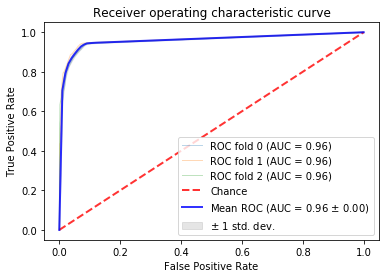

In [23]:
classifier = DecisionTreeClassifier(max_depth=7)
classification_roc_analysis(crossvalidation, Xnew, ynew, classifier, model_type)

### 3.3 Oversampling effects on the Logistic Regression model
If we look at the performance of the Logistic Regression model after oversampling the minority class, we observe an improvement to the net AUC & Recall metrics. AUC & Recall were 0.86 and 0.53 respectively with the actual data. After oversampling, we observe an increased AUC and Recall metrics of 0.94 and 0.69 respectively. The ROC curve below further highlights the improved AUC value and hence is a more reliable than the previous Logistic Regression model.

In [39]:
col_names = ['attribute2', 'attribute4', 'attribute7', 'attribute8']
state = 'reduced'
Xnew = Xnew[col_names]

# Logistic Regression
model_type = 'Logistic Regression'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, Xnew, ynew, crossvalidation, scoring_metrics, state)
print(grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']]
)

Performing grid search to determine the optimal parameters ...
          params  mean_test_AUC  rank_test_AUC  mean_test_Recall  rank_test_Recall  mean_test_Accuracy  rank_test_Accuracy
0   {'C': 0.001}       0.948701             13          0.691313                 1            0.830229                   1
1   {'C': 0.003}       0.948706             12          0.690010                 3            0.829959                   3
2   {'C': 0.005}       0.948714              1          0.690469                 2            0.830084                   2
3    {'C': 0.01}       0.948712              2          0.689914                 4            0.829863                   4
4    {'C': 0.03}       0.948712              5          0.689809                 5            0.829815                  13
5    {'C': 0.05}       0.948712              3          0.689809                 5            0.829851                   5
6     {'C': 0.1}       0.948712              4          0.689809            

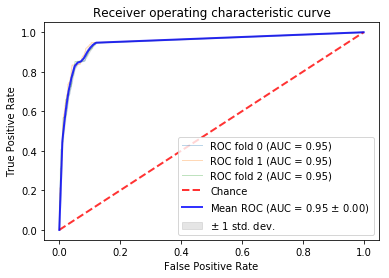

In [41]:
classifier = LogisticRegression(
            class_weight='balanced',
            random_state=0,
            C=0.005
        )
classification_roc_analysis(crossvalidation, Xnew, ynew, classifier, model_type)

### 3.4 Results Summary (post oversampling)

The below table summarizes the performance of the predictive models tested as part of this exercise post over-sampling. We can clearly see the improvement as compared to model optimization without oversampling.

| Predictive Model | AUC score | Recall |
| --- | --- | --- |
| __Decision Tree (all attr)__ | __0.989__ | __0.985__ |
| Decision Tree (reduced attr) | 0.960 | 0.938 |
| Logistic Regression (reduced attr) | 0.948 | 0.690 |